For this recitation, we will be exploring class hierarchies using shapes. We are going to start by defining a parent class Shape that will represent any shape that one may want to draw. Every shape is going to have a color attribute that will be used when plotting, and every shape will have a method to check if a point is inside the shape or not. Every shape will also have a method `addToPlot` that will draw that shape in a plot represented as a two-dimensional array.

Before we get to the shapes, here is a drawing function that we mostly won't explain, as it appeals to a popular Python library with a nontrivial interface.

In [9]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import math

def drawShapes(shapes):
    print(f"{Shape.num} shapes created")
    Z = np.array([[0 for j in range(0, 501)] for i in range(0, 501)])
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            p = (j, i)
            for s in shapes:
                if (s.checkPoint(p)):
                    Z[i][j] = s.getColor()

    fig, ax = plt.subplots()
    im = ax.imshow(Z, cmap=cm.tab20c,
                   origin='lower', extent=[0, 500, 0, 500],
                   vmax=10, vmin=0)

    plt.show()

Now our main base class for shapes:

In [42]:
class Shape():
    num = 0
    def __init__(self, color):
        self.color = color
        Shape.num = Shape.num + 1 # Centralized counting of how many shapes we have made lately.

    def checkPoint(self, p):
        '''
        Does point p fall within this shape?  Override in subclasses.
        '''
        raise NotImplementedError

    def center(self):
        '''
        What is the geomertic center of this shape?  Override in subclasses.
        '''
        raise NotImplementedError

    def getColor(self):
        return self.color

    # For simplicity of workflow, we mention these three methods near the start of class,
    # but we only explain their purposes near the end of class.
    def __add__(self, other):
        return Union(self, other)

    def __sub__(self, other):
        return Dif(self, other)

    def __mul__(self, other):
        return Intersect(self, other)

Now, we are ready to define some basic shapes.

In [44]:
class Box(Shape):
    def __init__(self, color, lowerLeft, upperRight):
        super().__init__(color)
        self.lowerLeft = lowerLeft
        self.upperRight = upperRight

    def checkPoint(self, p):
        return p[0] >= self.lowerLeft[0] and p[0] <= self.upperRight[0] \
            and p[1] >= self.lowerLeft[1] and p[1] <= self.upperRight[1]

    def center(self):
        return ((self.lowerLeft[0] + self.upperRight[0])/2,
                (self.lowerLeft[1] + self.upperRight[1])/2)

    def __repr__(self):
        return f"Box({self.lowerLeft}, {self.upperRight})"

    # A fun twist to add later in class: a version of the shape that is not filled in.
    def outline(self):
        rem = Box(self.color,
                  (self.lowerLeft[0] + 1, self.lowerLeft[1] + 1),
                  (self.upperRight[0] - 1, self.upperRight[1] - 1))
        return self - rem

A quick example of drawing boxes:

In [45]:
def boxTest():
    boxes = []
    for i in range(10, 200, 10):
        box = Box(2, (i, 2*i), (i+20, 2*i+40))
        boxes.append(box)
    return boxes

19 shapes created


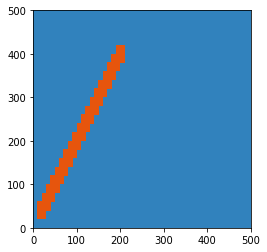

In [46]:
drawShapes(boxTest())

Next up: circles.

In [47]:
class Circle(Shape):
    def __init__(self, color, cent, radius):
        super().__init__(color)
        self.cent = cent
        self.radius = radius

    def checkPoint(self, p):
        dx = p[0] - self.cent[0]
        dy = p[1] - self.cent[1]
        return dx * dx + dy * dy <= self.radius * self.radius

    def center(self):
        return self.cent

    def __repr__(self):
        return f"Circle({self.cent}, {self.radius})"

    def outline(self):
        rem = Circle(self.color, (self.cent[0] + 1, self.cent[1] + 1), self.radius - 2)
        return self - rem

In [48]:
def circleTest(size=4):
    circ = Circle(1, (size, size), size/2)
    if size < 400:
        return circleTest(size * 2) + [circ]
    else:
        return [circ]

27 shapes created


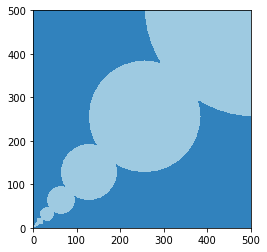

In [49]:
drawShapes(circleTest())

We can even define a square as a special kind of box.

In [50]:
class Square(Box):
    def __init__(self, color, mid, side):
        super().__init__(color, (mid[0] - side/2, mid[1] - side/2), (mid[0] + side/2, mid[1] + side/2))

    def __repr__(self):
        return f"Square({super().__repr__()})"

In [51]:
def squareTest1(center=(250,150), size=200):
    quad = []
    if size > 10:
        quad = [Square(1, center, size-1)]
        c0 = (center[0] - size/4 - 1, center[1] + 3*size/4+2)
        quad = quad + squareTest1(c0, size/2 - 2)
        c1 = (center[0] + size/4 + 1, center[1] + 3*size/4+2)
        quad = quad  + squareTest1(c1, size/2 - 2)

    return quad

42 shapes created


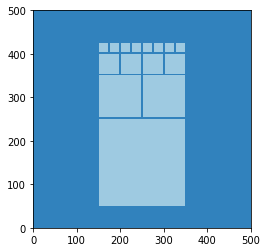

In [52]:
drawShapes(squareTest1())

It's also easy-enough to combine different kinds of shapes.

45 shapes created


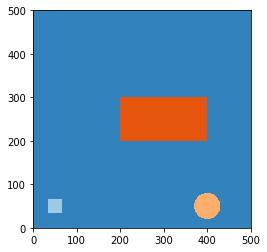

In [53]:
drawShapes([Square(1, (50, 50), 30), Box(2, (200, 200), (400, 300)), Circle(3, (400, 50), 30)])

Let's experiment with operators that move and resize shapes, as ingredients for describing more-complex compositions in terms of simpler ones.  The latter operation is the whole reason behind the `center` method that we've been including (which during class we'll realize at this point and add).

In [54]:
class Shift(Shape):
    def __init__(self, shape, offset):
        self.offset = offset
        self.shape = shape
        super().__init__(shape.getColor())

    def checkPoint(self, p):
        newp = (p[0] - self.offset[0], p[1] - self.offset[1])
        return self.shape.checkPoint(newp)

    def center(self):
        return (self.shape.center()[0] + self.offset[0], self.shape.center()[1] + self.offset[1])

    def __repr__(self):
        return f"Shift({self.shape} by {self.offset})"


class Scale(Shape):
    def __init__(self, shape, scale):
        self.scale = scale
        self.shape = shape
        super().__init__(shape.getColor())

    def checkPoint(self, p):
        cent = self.shape.center()
        newp = (p[0]/self.scale + cent[0]*(1 - 1/self.scale), p[1]/self.scale + cent[1]*(1-1/self.scale))
        return self.shape.checkPoint(newp)

    def center(self):
        return self.shape.center()

    def __repr__(self):
        return f"Scale({self.shape} by {self.scale})"

A moderately complex example:

In [55]:
def squareTest2(square, size):
    quad = []
    if size > 10:
        quad = [square]
        square = Scale(square, 1/2-1/size)
        c0 = (-size/4 - 1, 3*size/4 + 2)
        sq0 = Shift(square, c0)
        quad = quad + squareTest2(sq0, size/2-2)
        c1 = (size/4 + 1, 3*size/4 + 2)
        sq1 = Shift(square, c1)
        quad = quad + squareTest2(sq1, size/2-2)
    return quad

91 shapes created


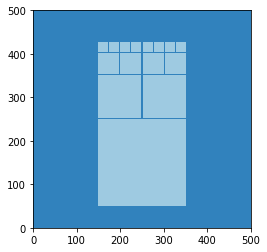

In [56]:
drawShapes(squareTest2(Square(1, (250, 150), 200), 200))

A trickier transformation is rotation.

In [57]:
class Rotate(Shape):
    def __init__(self, shape, angle):
        self.angle = angle
        self.shape = shape
        super().__init__(shape.getColor())

    def checkPoint(self, p):
        newp = (p[0] * math.cos(self.angle) - p[1] * math.sin(self.angle),
                p[1] * math.cos(self.angle) + p[0] * math.sin(self.angle))
        return self.shape.checkPoint(newp)

    def center(self):
        p = self.shape.center()
        return (p[0] * math.cos(self.angle) - p[1] * math.sin(self.angle),
                p[1] * math.cos(self.angle) + p[0] * math.sin(self.angle))

    def __repr__(self):
        return f"Shift({self.shape} by {self.angle})"

To enable another fun example, let's implement combination of shapes into larger shapes, or "union."

In [58]:
class Union(Shape):
    def __init__(self, shape1, shape2):
        super().__init__(shape1.getColor())
        self.shape1 = shape1
        self.shape2 = shape2

    def checkPoint(self, p):
        return self.shape1.checkPoint(p) or self.shape2.checkPoint(p)

    def center(self):
        c1 = self.shape1.center()
        c2 = self.shape2.center()
        return ((c1[0]+c2[0])/2, (c1[1]+c2[1])/2)

    def __repr__(self):
        return f"union({self.shape1} or {self.shape2})"

OK, now an example where we build up a composite shape gradually.  You might notice it's functionally identical to our previous example (`squareTest2`), though it builds one big shape instead of a list of many.

In [59]:
def squareTest3(square, size):
    quad = square
    if size/2 - 2 > 10:
        square = Scale(square, 1 / 2 - 1 / size)
        c0 = (-size/4 - 1, 3*size/4 + 2)
        sq0 = Shift(square, c0)
        quad = quad + squareTest3(sq0, size/2-2)
        c1 = (size/4 + 1, 3*size/4 + 2)
        sq1 = Shift(square, c1)
        quad = quad + squareTest3(sq1, size/2-2)
    return quad

127 shapes created


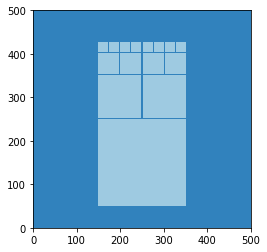

In [60]:
drawShapes([squareTest3(Square(1, (250, 150), 200), 200)])

We can also implement a fan-favorite kind of example, a fractal drawing.

In [61]:
def drawFractal(obj, center, size):
    for i in range(5):
        circ = Shift(Rotate(Circle(2, (3*size/4-3, 3*size/4-3), size/2-6), 2*math.pi/5*i), center)
        cent = circ.center()
        if size > 40:
            circ = drawFractal(circ, cent, size/2)
        obj = obj + circ
    return obj

748 shapes created


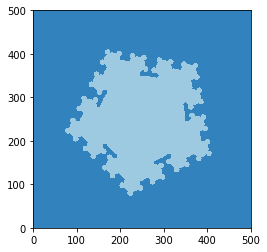

In [62]:
drawShapes([drawFractal(Circle(1, (250, 250), 100), (250, 250), 100)])

Another useful way of combining shapes is *subtraction*.

In [64]:
class Dif(Shape):
    def __init__(self, shape1, shape2):
        super().__init__(shape1.getColor())
        self.shape1 = shape1
        self.shape2 = shape2

    def checkPoint(self, p):
        return self.shape1.checkPoint(p) and not self.shape2.checkPoint(p)

    def center(self):
        return self.shape1.center()

    def __repr__(self):
        return f"dif({self.shape1} - {self.shape2})"

Subtraction is useful for describing a pretty spiral design.  First, a preliminary:

In [65]:
def spiral():
    box = Square(2, (0, 0), 100).outline()

    for i in range(0, 75):
        box = box + Shift(Rotate((Square(3, (10, 10), 100+i*4).outline()), math.pi/100*i*4), (250, 250))
    return box

1201 shapes created


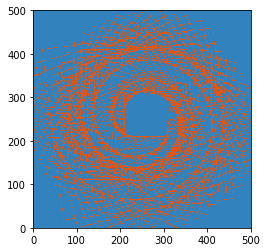

In [66]:
drawShapes([spiral()])

What happens if we subtract the spiral from the fractal?

2276 shapes created


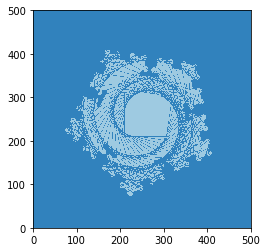

In [67]:
drawShapes([drawFractal(Circle(1, (250, 250), 100), (250, 250), 100) - spiral()])

Another classic operator is intersection of shapes.  Here's a definition for it, and we'll leave an exercise for the reader, to come up with nice drawings that use it!

In [41]:
class Intersect(Shape):
    def __init__(self, shape1, shape2):
        super().__init__(shape1.getColor())
        self.shape1 = shape1
        self.shape2 = shape2

    def checkPoint(self, p):
        return self.shape1.checkPoint(p) and self.shape2.checkPoint(p)

    def center(self):
        c1 = self.shape1.center()
        c2 = self.shape2.center()
        return ((c1[0]+c2[0])/2, (c1[1]+c2[1])/2)

    def __repr__(self):
        return f"intersect({self.shape1} and {self.shape2})"